# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.signal import find_peaks

# Load Data

In [ ]:
link = "https://drive.google.com/file/d/141MDAs7r-QxdSWoG9okm91UiRFCBQa1Q/view"
path = "https://drive.google.com/uc?id=" + link.split("/")[-2]
df = pd.read_csv(path)

# Verify shapes
print("Data Shape:", df.shape)

Data Shape: (4340, 8)


# Data Preview and Info

In [ ]:
# Display few rows of dataset
print("Data Preview:")
display(df.head())

Data Preview:


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [ ]:
df.columns = (
    df.columns
    .str.strip()
)

# Display information about the DataFrames
print("\nTrain Data Info:")
df.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB


## Insights from Initial Data Exploration

**Dataset Size and Structure**  
   - The **dataset** contains 4340 samples with 8 columns, including the target variable `selling_price`.

**Feature Overview**  
   - The datasets include all important attributes:  
     - **Numerical features:** `km_driven`.
     - **Categorical features:** `year`, `fuel`, `seller_type`, `transmission`, `owner`.
   - The target variable is numerical.

**Data Completeness**  
   - The dataset have **no missing values**.
   - Data types are appropriate: numerical feature is int64 and categorical features is object.

In [ ]:
def label_year(row):
  if row["year"] <= 1999:
    return "Old (1990–1999)"
  elif row["year"] > 1999 and row["year"] <= 2009:
    return "Mid-range (2000–2009)"
  else:
    return "New (2010–2017)"

df["year_group"] = df.apply(label_year, axis=1)
df.drop(columns=["year", "name"], axis=1, inplace=True)

In [ ]:
cat_features = ["fuel", "seller_type", "transmission", "owner", "year_group"]
target_feature = "selling_price"
def convert_cat(features, df = df):
    for feature in features:
        if feature in df.columns:
            df[feature] = df[feature].astype("category")
convert_cat(cat_features, df=df)

# Display information about the DataFrames
print("\nTrain Data Info:")
df.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   selling_price  4340 non-null   int64   
 1   km_driven      4340 non-null   int64   
 2   fuel           4340 non-null   category
 3   seller_type    4340 non-null   category
 4   transmission   4340 non-null   category
 5   owner          4340 non-null   category
 6   year_group     4340 non-null   category
dtypes: category(5), int64(2)
memory usage: 89.9 KB


In [ ]:
print("Data describe:")
cm = sns.light_palette("blue", as_cmap=True)
display(df.drop(columns=target_feature, axis=1).describe().T.style.background_gradient(cmap=cm))

Data describe:


,count,mean,std,min,25%,50%,75%,max
km_driven,4340.000000,66215.777419,46644.102194,1.000000,35000.000000,60000.000000,90000.000000,806599.000000


## Descriptive Insights – Numerical Features

* Cars in the dataset have a **wide range of usage**, from just **1 km** to over **800,000 km**.
* The **average mileage is around 66,000 km**, with a median of **60,000 km** – suggesting that most cars fall within a typical usage range.
* **75% of cars have been driven less than 90,000 km**, indicating that high-mileage cars are relatively rare.
* The **extremely high maximum value (806,599 km)** highlights the presence of strong outliers that may require attention during preprocessing.

**Overall, the distribution of `km_driven` shows a realistic concentration around 35,000–90,000 km, but also contains extreme outliers.**

In [ ]:
num_features = ["selling_price", "km_driven"]
print("Data describe:")
cm = sns.light_palette("blue", as_cmap=True)
display(df.drop(columns=num_features, axis=1).describe().T.style.background_gradient(cmap=cm, subset=["unique", "freq"]))

Data describe:


,count,unique,top,freq
fuel,4340,5,Diesel,2153
seller_type,4340,3,Individual,3244
transmission,4340,2,Manual,3892
owner,4340,5,First Owner,2832
year_group,4340,3,New (2010–2017),3526


## Descriptive Insights from Dataset Statistics

* **Fuel**: There are 5 fuel types, with **Diesel** being the most common (2,153 cars).
* **Seller Type**: 3 categories, dominated by **Individual sellers** (3,244 cars), showing that most transactions come from individuals.
* **Transmission**: 2 types, with **Manual transmission** overwhelmingly dominant (3,892 cars).
* **Owner**: 5 ownership levels, but most cars are **First Owner** (2,832 cars), reflecting that the used-car market is largely made up of first-hand vehicles.
* **Year Group**: 3 groups, with **New (2010–2017)** cars strongly prevailing (3,526 cars), indicating the dataset leans toward relatively newer cars.

**Overall**: The dataset shows clear imbalance in some categorical features: **Manual transmission, Individual sellers, Diesel fuel, First Owner, and New (2010–2017) cars** are dominant.

# Data Quality Checks

## Missing Value

In [ ]:
def displayNULL(df, dataset_name=None):
    total_rows = len(df)

    missing_df = df.isnull().sum().reset_index()
    missing_df.columns = ["Feature", "Missing_Count"]
    missing_df = missing_df[missing_df["Missing_Count"] > 0]
    missing_df["Missing_%"] = (missing_df["Missing_Count"] / total_rows * 100).round(2)
    missing_df = missing_df.sort_values(by="Missing_Count", ascending=False).reset_index(drop=True)

    total_missing = missing_df["Missing_Count"].sum()

    print("=" * 40)
    if dataset_name:
        print(f"🔎 Missing Value Summary for: {dataset_name}")
    else:
        print("🔎 Missing Value Summary:")
    print("=" * 40)

    if total_missing == 0:
        print(f"✅ No missing values detected in {total_rows:,} rows.")
    else:
        try:
            from tabulate import tabulate
            print(tabulate(missing_df, headers="keys", tablefmt="pretty", showindex=False, colalign=("left", "left", "left")))
        except ImportError:
            print(missing_df.to_string(index=False))

        print(f"\n⚠️  Total missing values: {total_missing:,} out of {total_rows:,} rows.")

print("Missing value in the dataset: ")
displayNULL(df, dataset_name="Data Set")

Missing value in the dataset: 
🔎 Missing Value Summary for: Data Set
✅ No missing values detected in 4,340 rows.


## Duplicate Value

In [ ]:
def check_duplicates_report(df, dataset_name):
    duplicates_count = df.duplicated().sum()
    total_rows = len(df)

    print("=" * 40)
    print(f"🔍 {dataset_name} Duplicate Analysis")
    print("=" * 40)

    if duplicates_count == 0:
        print(f"✅ No duplicates found in {total_rows:,} rows")
    else:
        print(f"⚠️  {duplicates_count} duplicates found ({duplicates_count/total_rows:.2%})")
        print(f"    Total rows affected: {duplicates_count:,}/{total_rows:,}")

datasets = {
    "Data": df
}

duplicate_summary = {}
check_duplicates_report(df, "Data")
duplicate_summary["Data"] = {
    "duplicates": df.duplicated().sum(),
    "total_rows": len("Data")
}
print()

🔍 Data Duplicate Analysis
⚠️  1105 duplicates found (25.46%)
    Total rows affected: 1,105/4,340



In [ ]:
df = df.drop_duplicates()
check_duplicates_report(df, "Data")
duplicate_summary["Data"] = {
    "duplicates": df.duplicated().sum(),
    "total_rows": len("Data")
}
print()

🔍 Data Duplicate Analysis
✅ No duplicates found in 3,235 rows



## Checking Outlier Value

In [ ]:
def checking_outlier(list_feature, df, dataset_name):
    print("=" * 40)
    print(f"🔍 {dataset_name} Checking outlier")
    print("=" * 40)
    outlier_info = []
    for feature in list_feature:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]
        if len(outliers) == 0:
            pass
        else:
            outlier_info.append({
            "Feature": feature,
            "Outlier Count": len(outliers),
            # "Outlier Detail": outliers.tolist()
            })
    return pd.DataFrame(outlier_info)

checking_outlier(list_feature=num_features, df=df, dataset_name="Training data")

🔍 Training data Checking outlier


,Feature,Outlier Count
0,selling_price,167
1,km_driven,106


## Data Quality Insights: Missing Values, Duplicates and Outliers

**Missing Values Analysis**

- We conducted a thorough check for missing values across the datasets.  
- **No missing values** in the datasets.

**Duplicate Records Analysis**

- We examined the datasets for duplicate rows that could bias the model.
- **The duplicate records** were found in dataset: 1105 duplicates found (25.46%) -> Total rows affected: 1,105/4,340
-> We removed the duplicate records and re-check again to ensure no duplicate records exist in dataset.

**Outliers Records Analysis**

- We also examined the datasets for checking outliers.
- **The outliers** were found in dataset at features **selling_price** and **km_driven**. But we can not remove them since these outliers reflect reality and we will use Robust Scaler to scale data for outlier features.

# Visualize

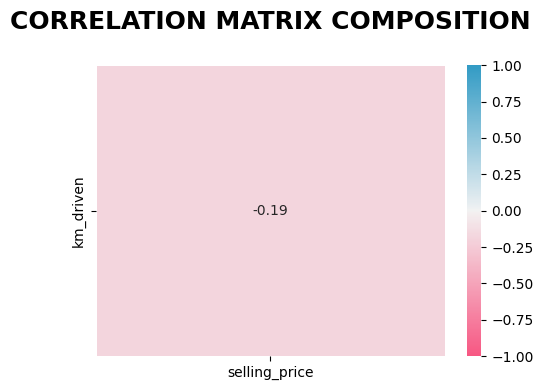

In [ ]:
corr_matrix = df.corr(numeric_only=True)
# one_like can build a matrix of boolean(True, False) with the same shape as our data
ones_corr = np.ones_like(corr_matrix, dtype=bool)
mask = np.triu(ones_corr)
adjusted_mask = mask[1:, :-1]
adjusted_cereal_corr = corr_matrix.iloc[1:, :-1]

fig, ax = plt.subplots(figsize = (5, 4))
# That method uses HUSL colors, so you need hue, saturation, and lightness.
# I used hsluv.org to select the colors of this chart.
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

sns.heatmap(data=adjusted_cereal_corr, mask=adjusted_mask,
            annot=True, fmt=".2f", cmap=cmap,
            vmin=-1, vmax=1, linecolor="white", linewidths=0.5)

title = "CORRELATION MATRIX COMPOSITION\n"
ax.set_title(title, loc="center", fontsize=18, weight="bold");
plt.tight_layout()
plt.show()

## **Correlation Insights**

* **km\_driven** has a **weak negative correlation (-0.19)** with **selling\_price**.
* This means: the more kilometers a car has been driven, the lower its selling price tends to be, but the relationship is not strong.
* This suggests that besides mileage, other factors (such as year of manufacture, condition, brand, etc.) have a greater influence on selling price.

**Conclusion:** Mileage affects car price, but its impact is relatively small.

# selling_price Distribution

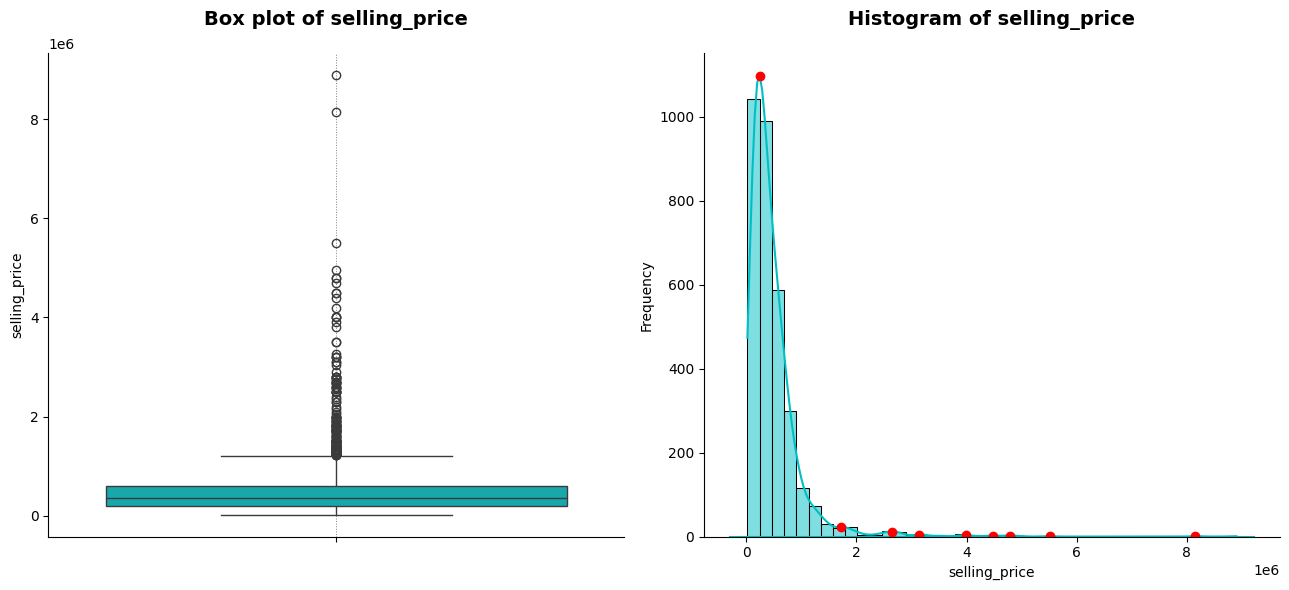

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(13, 6))

sns.boxplot(data=df, y = "selling_price", ax=ax[0], color="#00BFC4")
ax[0].set_title(f"Box plot of selling_price", fontsize=14, pad=20, weight="bold")
ax[0].grid(axis="x", color="gray", linestyle=":", linewidth=0.7)
ax[0].set_ylabel("selling_price")
sns.despine(ax=ax[0], top=True, right=True, left=False, bottom=False)

sns.histplot(data=df, x = "selling_price", ax=ax[1], color="#00BFC4", kde=True, bins=40)
ax[1].set_title(f"Histogram of selling_price", fontsize=14, pad=20, weight="bold")
ax[1].set_xlabel("selling_price")
ax[1].set_ylabel("Frequency")
# ax[1].grid(axis="x", color="gray", linestyle=":", linewidth=0.7)
sns.despine(ax=ax[1], top=True, right=True, left=False, bottom=False)

# Extract KDE values to find peaks
kde = sns.kdeplot(df["selling_price"], ax=ax[1], color="#00BFC4").lines[0].get_data()
kde_x, kde_y = kde[0], kde[1]
peaks, _ = find_peaks(kde_y)

# Highlight peaks
for peak_idx in peaks:
    plt.plot(kde_x[peak_idx], kde_y[peak_idx], "ro")  # Red dots on peaks

plt.tight_layout()
plt.show()

**Insights – Selling Price**

* The distribution is **highly right-skewed**: most cars have low selling prices, with only a few very expensive ones.
* **Many outliers** are present: some cars have selling prices above 8 million (based on the dataset’s unit), far beyond the main cluster.
* The central values are concentrated around **0 – 500,000**, indicating that most cars fall within the low to mid-price segment.

**Conclusion:** Selling price is right-skewed, concentrated at lower levels, with very high outliers that should be considered for preprocessing before modeling.


# Data Pre-processing

In [ ]:
X = df.drop("selling_price", axis=1)
y = df["selling_price"].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [ ]:
feature_num_robust = ["km_driven"]

# Currently, the features age and length_of_service contain outliers, so we will use RobustScaler to scale them in order to reduce the impact of these outliers.
num_robust_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

cat_onehot_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")) # Handling Text and Categorical Attributes
])

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ("num_robust", num_robust_transformer, feature_num_robust),
    ("cat_onehot", cat_onehot_transformer, cat_features)
])

preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num_robust',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['km_driven']),
                                ('cat_onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['fuel', 'seller_type', 'transmission',
                                  'owner', 'year_group'])])

In [ ]:
X_train_prepared = preprocessor.transform(X_train)
X_val_prepared = preprocessor.transform(X_val)
list_feature_prepared = preprocessor.get_feature_names_out().tolist()
list_feature_prepared

['num_robust__km_driven',
 'cat_onehot__fuel_CNG',
 'cat_onehot__fuel_Diesel',
 'cat_onehot__fuel_Electric',
 'cat_onehot__fuel_LPG',
 'cat_onehot__fuel_Petrol',
 'cat_onehot__seller_type_Dealer',
 'cat_onehot__seller_type_Individual',
 'cat_onehot__seller_type_Trustmark Dealer',
 'cat_onehot__transmission_Automatic',
 'cat_onehot__transmission_Manual',
 'cat_onehot__owner_First Owner',
 'cat_onehot__owner_Fourth & Above Owner',
 'cat_onehot__owner_Second Owner',
 'cat_onehot__owner_Test Drive Car',
 'cat_onehot__owner_Third Owner',
 'cat_onehot__year_group_Mid-range (2000–2009)',
 'cat_onehot__year_group_New (2010–2017)',
 'cat_onehot__year_group_Old (1990–1999)']

# Modeling

In [ ]:
# Function to evaluate regression models
def evaluate_model(model, X_train, X_val, y_train, y_val):
    RESET = "\033[0m"
    BLUE = "\033[94m"
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    y_val_real = y_val
    y_pred_real = y_pred

    # Metric: R²
    r2 = r2_score(y_val_real, y_pred_real)
    print(f"Model: {model.__class__.__name__}{RESET}")
    print(f"Coefficient of Determination (R²): {BLUE}{r2:.2f}{RESET}")
    print("-" * 80)

    # Metric: MAE
    mae = mean_absolute_error(y_val_real, y_pred_real)
    print(f"Mean Absolute Error (MAE): {BLUE}{mae:.2f}{RESET}")
    print("-" * 80)

    # Metric: MSE
    mse = mean_squared_error(y_val_real, y_pred_real)
    print(f"Mean Squared Error (MSE): {BLUE}{mse:.2f}{RESET}")
    print("-" * 80)

    # Metric: RMSE
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {BLUE}{rmse:.2f}{RESET}")
    print("-" * 80)

    fig, ax = plt.subplots(1, 2, figsize=(12, 7))

    # ----- Plot 1: Predicted vs. Actual -----
    ax[0].scatter(y_val_real, y_pred_real, alpha=0.4, color="royalblue")
    ax[0].plot(
        [y_val_real.min(), y_val_real.max()],
        [y_val_real.min(), y_val_real.max()],
        "r--", lw=2, label="Perfect Prediction (y=x)"
    )
    ax[0].set_xlabel("Actual Values")
    ax[0].set_ylabel("Predicted Values")
    ax[0].set_title("Predicted vs. Actual (Validation Set)", weight="bold", pad=20)
    ax[0].legend()
    ax[0].grid(True, alpha=0.2)

    # ----- Plot 2: Residual Plot -----
    residuals = y_val_real - y_pred_real
    ax[1].scatter(y_val_real, residuals, alpha=0.5)
    ax[1].axhline(0, color="red", linestyle="--", lw=2)
    ax[1].set_xlabel("Actual Values")
    ax[1].set_ylabel("Prediction Error (Residuals)")
    ax[1].set_title("Residual Plot", weight="bold", pad=20)
    ax[1].grid(True, alpha=0.2)

    # Optimize layout
    plt.tight_layout()
    plt.show()

## Ridge

In [ ]:
# Initialize & train the model
ridge_reg = Ridge(random_state=42, max_iter=50000)
ridge_reg.fit(X_train_prepared, y_train)

Ridge(max_iter=50000, random_state=42)

Model: Ridge
Coefficient of Determination (R²): 0.35
--------------------------------------------------------------------------------
Mean Absolute Error (MAE): 249801.46
--------------------------------------------------------------------------------
Mean Squared Error (MSE): 238012335653.23
--------------------------------------------------------------------------------
Root Mean Squared Error (RMSE): 487865.08
--------------------------------------------------------------------------------


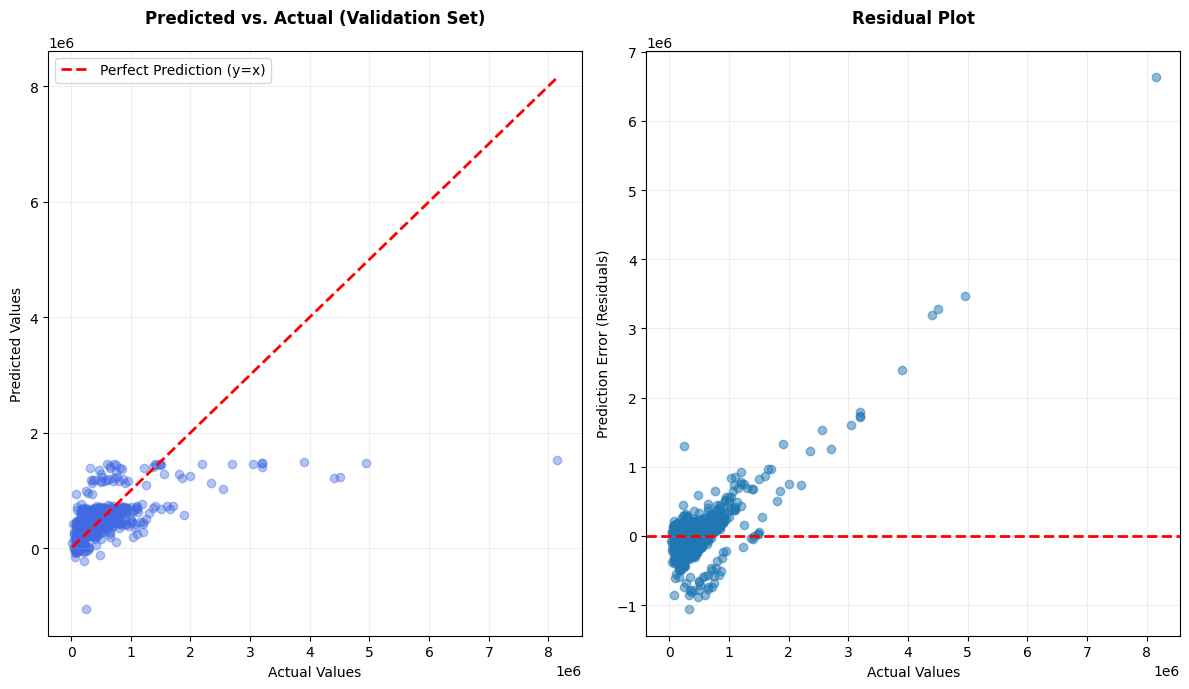

In [ ]:
# Evaluate
evaluate_model(model=ridge_reg, X_train=X_train_prepared, X_val=X_val_prepared, y_train=y_train, y_val=y_val)

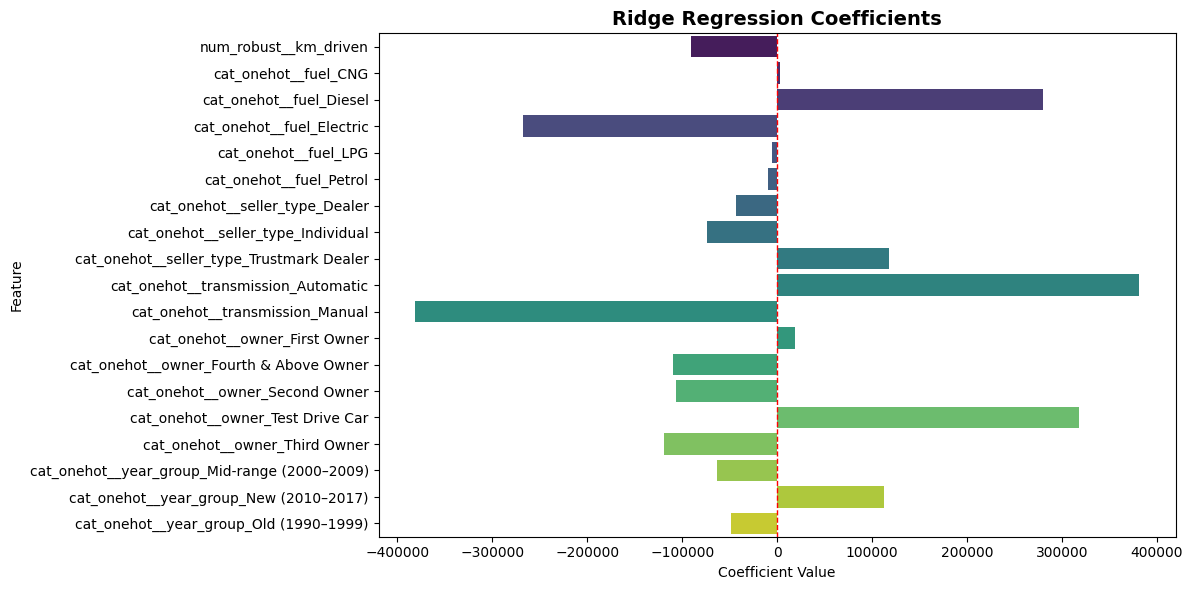

In [ ]:
coef_df = pd.DataFrame({
    "Feature": list_feature_prepared,
    "Coefficient": ridge_reg.coef_
})

plt.figure(figsize=(12,6))
sns.barplot(data=coef_df, x="Coefficient", y="Feature", palette="viridis", hue="Feature")

plt.title("Ridge Regression Coefficients", fontsize=14, weight="bold")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.axvline(0, color="red", linestyle="--", linewidth=1)
plt.tight_layout()
plt.show()

**Insights – Ridge Regression Coefficients**

* **Transmission**:

  * `Automatic` has a very large positive coefficient → strongly increases the selling price.
  * `Manual` shows a strong negative coefficient → usually associated with lower-priced cars.

* **Fuel Type**:

  * `Diesel` stands out with a positive coefficient → diesel cars tend to have higher selling prices.
  * `Electric` shows a strong negative coefficient → in this dataset, electric cars are priced lower than expected.

* **Owner**:

  * `Test Drive Car` and `Third Owner` have strong positive coefficients → surprisingly associated with higher prices (likely due to data bias).
  * `First Owner` only shows a slight positive impact.

* **Year Group**:

  * Newer cars (`2010–2017`) have positive coefficients → linked to higher prices.
  * Older cars (`1990–1999`) show negative coefficients → clearly associated with lower prices.

* **Km Driven**:

  * Negative coefficient → the more kilometers driven, the lower the selling price, which aligns with expectations.

**Conclusion:** Car prices are most strongly influenced by **transmission type (Automatic vs Manual), fuel type (Diesel vs Electric), year group, and kilometers driven**. These variables are the **key drivers** in the Ridge model.


## Lasso

In [ ]:
# Initialize & train the model
lasso_reg = Lasso(random_state=42, max_iter=50000)
lasso_reg.fit(X_train_prepared, y_train)

Lasso(max_iter=50000, random_state=42)

Model: Lasso
Coefficient of Determination (R²): 0.35
--------------------------------------------------------------------------------
Mean Absolute Error (MAE): 249813.82
--------------------------------------------------------------------------------
Mean Squared Error (MSE): 237925300070.20
--------------------------------------------------------------------------------
Root Mean Squared Error (RMSE): 487775.87
--------------------------------------------------------------------------------


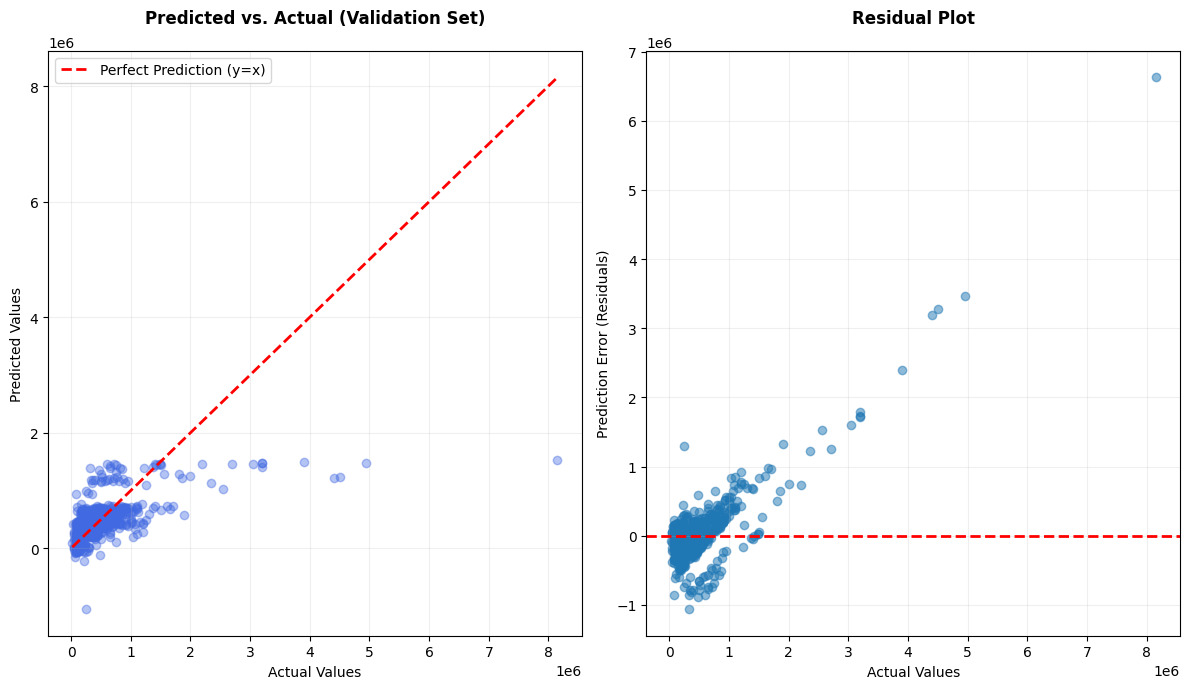

In [ ]:
# Evaluate
evaluate_model(model=lasso_reg, X_train=X_train_prepared, X_val=X_val_prepared, y_train=y_train, y_val=y_val)

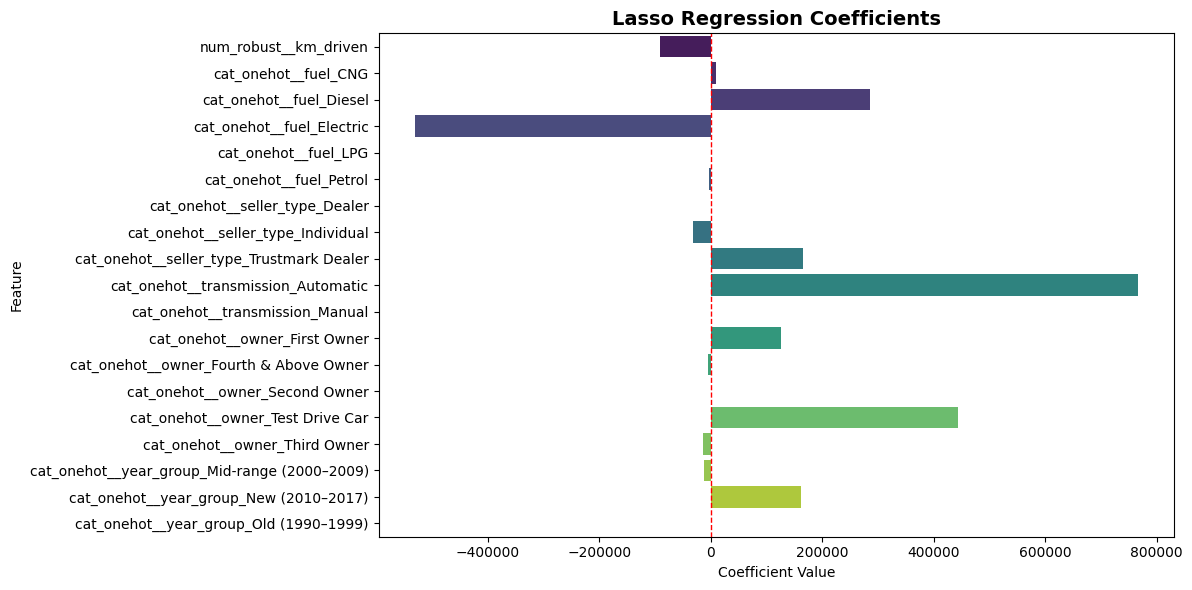

In [ ]:
coef_df = pd.DataFrame({
    "Feature": list_feature_prepared,
    "Coefficient": lasso_reg.coef_
})

plt.figure(figsize=(12,6))
sns.barplot(data=coef_df, x="Coefficient", y="Feature", palette="viridis", hue="Feature")

plt.title("Lasso Regression Coefficients", fontsize=14, weight="bold")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.axvline(0, color="red", linestyle="--", linewidth=1)
plt.tight_layout()
plt.show()

**Insights – Lasso Regression Coefficients**

* **Transmission**:

  * `Automatic` has a very large positive coefficient → strongly increases the selling price.
  * `Manual` has a slight negative coefficient → manual cars are associated with lower prices.

* **Fuel Type**:

  * `Diesel` retains a clear positive coefficient → diesel cars tend to have higher prices.
  * `Electric` shows a strong negative coefficient → electric cars in this dataset are priced lower.
  * Other fuel types (`Petrol, LPG, CNG`) are shrunk close to zero by Lasso → minimal influence.

* **Owner**:

  * `Test Drive Car` and `Second/Third Owner` still show notable positive coefficients.
  * Other ownership categories are pushed near zero by Lasso.

* **Year Group**:

  * Newer cars (`2010–2017`) have positive coefficients → associated with higher prices.
  * Older cars (`1990–1999`) have little to no influence after regularization.

* **Km Driven**:

  * Retains a negative coefficient, confirming that more kilometers driven reduces the selling price.

**Conclusion:** With Lasso (L1 regularization), many weak features are eliminated (coefficients ≈ 0). The strongest drivers of car price are **Transmission (Automatic vs Manual), Fuel type (Diesel/Electric), kilometers driven, specific ownership groups (Test Drive Car, Second/Third Owner), and Year group (newer cars)**.
